In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.xtras import load_pickle

import matplotx
import numpy as np
import pandas as pd

from scipy.stats import sem

from gptchem.plotsettings import *

%matplotlib inline

In [3]:
all_res = glob("out/**/*.pkl")

In [4]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded["representation"]
    num_points = loaded["num_train_points"]

    metrics = {
        "representation": loaded["representation"],
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["gpr_baseline"]["mean_absolute_error"],
        "max_error": loaded["gpr_baseline"]["max_error"],
        "mse": loaded["gpr_baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [5]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [6]:
compiled_grouped_res = compiled_res.groupby(["representation", "num_train_points"]).agg(
    ["mean", "std", sem]
)

In [7]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std", sem])

In [8]:
compiled_grouped_res

mae                     max_error  \
                                     mean       std       sem      mean   
representation num_train_points                                           
InChI          10                2.554313  0.400878       NaN  7.613333   
               50                2.375387  0.223595       NaN  7.775833   
               100               2.221215  0.137343  0.038092  7.422308   
               200               2.113218  0.120672  0.033468  7.431538   
               500               2.005830  0.108008  0.031179  6.897500   
SELFIES        10                2.435240  0.429573       NaN  7.506667   
               50                2.258663  0.184044  0.049188  7.782143   
               100               2.253269  0.132399  0.035385  7.746429   
               200               2.155729  0.118497  0.032865  7.869231   
               500               2.110754  0.115715  0.032094  7.686154   
SMILES         10                2.605282  0.466473       NaN  7.837647   
               50                2.451109  0.209715       NaN  7.967143   
               100               2.267647  0.210680       NaN  7.920000   
               200               2.117760  0.085227       NaN  7.750588   
               500               1.976915  0.106469  0.027490  7.159333   

                                                           mse            \
                                      std       sem       mean       std   
representation num_train_points                                            
InChI          10                0.612721       NaN   9.701856  2.952505   
               50                0.889836       NaN   8.499643  1.502382   
               100               1.172434  0.325175   7.551346  1.038583   
               200               0.808722  0.224299   6.875147  0.932689   
               500               0.657587  0.189829   6.277621  0.710502   
SELFIES        10                0.681048       NaN   8.943039  2.918513   
               50                0.881949  0.235711   7.802612  1.327514   
               100               0.982372  0.262550   7.759743  1.112564   
               200               0.887097  0.246036   7.148008  0.864160   
               500               0.843480  0.233939   7.065543  0.784991   
SMILES         10                1.134898       NaN  10.107959  3.465812   
               50                1.168170       NaN   9.139113  1.487803   
               100               0.790822       NaN   7.837598  1.494908   
               200               0.781557       NaN   6.973827  0.510607   
               500               0.728173  0.188013   6.256449  0.745054   

                                           
                                      sem  
representation num_train_points            
InChI          10                     NaN  
               50                     NaN  
               100               0.288051  
               200               0.258682  
               500               0.205104  
SELFIES        10                     NaN  
               50                0.354793  
               100               0.297345  
               200               0.239675  
               500               0.217717  
SMILES         10                     NaN  
               50                     NaN  
               100                    NaN  
               200                    NaN  
               500               0.192372

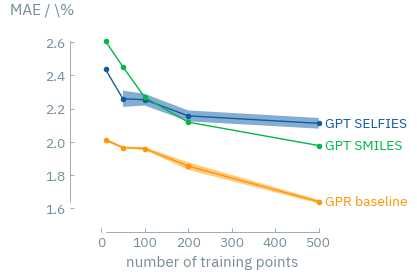

In [9]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1)
ax.plot(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"],
    label="GPT SELFIES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SELFIES", :]["mae"]["sem"],
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SELFIES", :]["mae"]["sem"],
    alpha=.5
)

ax.plot(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"],
    label="GPT SMILES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SMILES", :]["mae"]["sem"],
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SMILES", :]["mae"]["sem"],
    alpha=0.5,
)

ax.plot(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped["mae"]["mean"],
    label="GPR baseline",
    marker="o",
)

ax.fill_between(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["sem"],
    compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["sem"],
    alpha=0.5,
)

matplotx.line_labels()

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top("MAE / \%", y_pad=-0.05, x_pad=0.02)
# ax.set_xscale('log')

range_frame(
    ax, 
     compiled_gpr_grouped.loc[:].index,
     np.nan_to_num(np.stack(
        [    compiled_gpr_grouped.loc[:]["mae"]["mean"], 
        compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
        ]
     ).flatten(), 1.7)
)

fig.savefig("opv_regression_res.pdf", bbox_inches="tight")